# Active Learning (AL)

**TL;DR**  

In this notebook, we provide a tutorial on **active learning (AL)** in the context of emulators and simulators. **Active learning** is a strategy where an **emulator** selectively queries a computationally expensive **simulator** for labels, improving prediction accuracy while minimizing simulation costs. We introduce different AL settings—**stream-based, pool-based, and membership query learning**—but focus primarily on the **stream-based setting**, where data arrives sequentially, and the emulator must decide in real-time whether to query the simulator.

To formalize this, we define a class hierarchy for **stream-based active learners**, which can be visualized using `Learner.plot_hierarchy()`: 

```scss
Learner [Abstract]
└── Stream [Abstract]
    ├── Random [Concrete]
    └── Threshold [Abstract]
        ├── Uncertainty [Concrete]
        │   └── PID(Uncertainty) [Concrete]
        └── Diversity [Concrete]
            └── PID(Diversity) [Concrete]
```

This structure captures different querying strategies:
- **`Random`** queries the simulator with a fixed probability.
- **`Threshold`**-based learners decide based on a computed score, such as **uncertainty** (model confidence) or **diversity** (novelty of the input).
- **`PID`** learners dynamically adjust their threshold using **Proportional-Integral-Derivative (PID) control** to maintain a target query rate.

Through this hierarchy, we systematically implement and compare different active learning strategies in the **stream-based setting**.

**Imports**

Below we import the neccesary components for this tutorial.

In [1]:
# AutoEmulate
from autoemulate.emulators import GaussianProcess
from autoemulate.experimental_design import LatinHypercube

# Python
from dataclasses import dataclass, field
from typing import Tuple, List
from abc import ABC, abstractmethod
from inspect import isabstract

# Libraries
import tqdm, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.spatial.distance import cdist
from anytree import Node, RenderTree
from sklearn.metrics import r2_score

## Overview of AL

In AutoEmulate, we use **inexpensive** emulator models to approximate **expensive** simulations. However, these emulators require training data from the simulator. Therefore, a critical challenge is deciding which input points to query from the simulator to optimize the emulator's performance while minimizing simulation costs. Fundamentally, we can view both the simulator and emulator as functions that map from an input space $ \mathcal{X}$ (independent variables) to an output space $ \mathcal{Y}$ (dependent variables):
$$
\mathrm{Simulator}: \mathcal{X} \to \mathcal{Y} \qquad \text{and} \qquad \mathrm{Emulator}: \mathcal{X} \to \mathcal{Y}.
$$

In practice, our primary goal is to provide reliable predictions with the emulator. When the emulator is too uncertain about a user's query, we query the simulator to obtain a more accurate output and then update the emulator accordingly. This scenario is naturally addressed using a **stream-based** active learning approach: as inputs arrive sequentially, we decide whether to rely on the emulator or to query the simulator based on the emulator's uncertainty.

For context, AL strategies can be categorized into three main scenarios:

| **Active Learning Strategy** | **Candidate Set** | **Query Output** | **Query Method Signature** | **Description** |
|------------------------------|-------------------|------------------|----------------------------|-----------------|
| **Membership-Based**         | Any candidate subset $S \subseteq \mathcal{X}$ (where $\mathcal{X}$ is the entire continuous input space) | A single query point $x \in S$ | $q: \mathcal{P}(\mathcal{X}) \to \mathcal{X}$, with $q(S) \in S$ | The learner synthesizes queries by selecting an informative point from a candidate subset of the entire space. Here, $\mathcal{P}(\mathcal{X})$ is the powerset of $\mathcal{X}$ (i.e. the set of all subsets of $\mathcal{X}$). |
| **Pool-Based**               | Any candidate subset $S \subseteq \hat{\mathcal{X}}$ (where $\hat{\mathcal{X}} \subseteq \mathcal{X}$ is a fixed, finite pool) | A single query point $x \in S$ | $q: \mathcal{P}(\hat{\mathcal{X}}) \to \hat{\mathcal{X}}$, with $q(S) \in S$ | The learner selects an informative point from a fixed pool of unlabeled data. Here, $\mathcal{P}(\hat{\mathcal{X}})$ denotes the powerset of the fixed pool. |
| **Stream-Based**             | Individual inputs $x \in \mathcal{X}$ arriving sequentially | A binary decision $d \in \{0,1\}$ (to label or skip) | $q: \mathcal{X} \to \{0,1\}$ | The learner processes each incoming input and decides in real time whether to query its label. This approach is particularly useful when we want to query the simulator only when the emulator's prediction is uncertain. |

To formalise, we can make the following API for active learning in general, where there are three main components:

`Simulator`: 
- `__call__` supplies us with output labels given inputs.

`Emulator`: 
- `__call__`: supplies us with output predictions (mean and uncertainty) given inputs.

`Learner`: 
- Uses `Emulator` to determine where to query `Simulator` to improve `Emulator`.
- `query`: a method with any of the query signatures given in the table above.
- `update`: updates the emulator's training set with a new point (this could eventually be updated to "batch mode").
- `__call__`: uses the `query` method and the `update` method together. Note that the input to `query` and `__call__` should be the same.
- `registry`, `hierarchy`, and `plot_hierarchy` are neccesary for producing the inheritence illustration in the TL;DR above. You don't really need to worry about this, but feel free to inspect!


In [2]:
class Simulator(ABC):
    """Abstract base class for simulator models."""
    @abstractmethod
    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
        Simulate outputs for the given inputs.
        
        Args:
            X: Input array.
        
        Returns:
            Simulated outputs.
        """
        pass

class Emulator(ABC):
    """Abstract base class for emulator models."""
    @abstractmethod
    def __call__(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Return predictions and uncertainties for given inputs.
        
        Args:
            X: Input array.
        
        Returns:
            Tuple of predictions and uncertainties.
        """
        pass

    @abstractmethod
    def fit(self, X: np.ndarray, Y: np.ndarray):
        """
        Train the emulator on provided input-output pairs.
        
        Args:
            X: Training inputs.
            Y: Training outputs.
        """
        pass

@dataclass(kw_only=True)
class Learner(ABC):
    """
    Base class for active learning learners.
    
    Attributes:
        simulator: The simulator function.
        emulator: The emulator function.
        X_train: Array of training inputs.
        Y_train: Array of training outputs.
    """
    simulator: Simulator
    emulator: Emulator
    X_train: np.ndarray  # (n, a) array of inputs
    Y_train: np.ndarray  # (n, b) array of outputs

    def __post_init__(self):
        """Fit the emulator on the initial training data."""
        self.emulator.fit(self.X_train, self.Y_train)

    @abstractmethod
    def __call__(self, *args):
        """
        Execute the AL decision and update the training set.
        """
        pass

    @abstractmethod
    def query(self, *args) -> np.ndarray | bool:
        """
        Decide which inputs to query.
        
        This method should be implemented by subclasses.
        Note that the method's signature can depend on the AL scenario.
        """
        pass

    def update(self, x: np.ndarray):
        """
        Query the simulator for the given input and update the training set.
        
        Args:
            x: Input sample.
        """
        x = x.reshape(1, -1)
        y = self.simulator(x)
        self.X_train = np.concatenate([self.X_train, x])
        self.Y_train = np.concatenate([self.Y_train, y])
        self.emulator.fit(self.X_train, self.Y_train)

    @classmethod
    def registry(cls) -> dict:
        """
        Recursively builds a dictionary mapping class names to class objects,
        starting from cls.
        
        Returns:
            A dictionary where keys are class names and values are the class objects.
        """
        d = {cls.__name__: cls}
        for sub in cls.__subclasses__():
            d.update(sub.registry())
        return d

    @classmethod
    def hierarchy(cls) -> List[Tuple[str, str]]:
        """
        Recursively collects the inheritance relationships (as ordered pairs)
        starting from cls.
        
        Returns:
            A list of tuples where each tuple is (parent_class_name, child_class_name).
        """
        edges = []
        for base in cls.__subclasses__():
            edges.append((cls.__name__, base.__name__))
            edges.extend(base.hierarchy())
        return edges

    @classmethod
    def plot_hierarchy(cls):
        """
        Builds and prints an ASCII tree of the class hierarchy starting from cls.
        
        Each class name is annotated with a marker indicating whether it is abstract:
          - [Abstract] for classes with one or more abstract methods.
          - [Concrete] for classes that are fully implemented.
          
        The method uses the anytree library to construct and render the tree.
        """
        pairs = cls.hierarchy()
        nodes = {name: Node(name) for pair in pairs for name in pair}
        for parent, child in pairs:
            nodes[child].parent = nodes[parent]
        root = nodes[cls.__name__]
        registry = cls.registry()
        for pre, _, node in RenderTree(root):
            class_obj = registry.get(node.name)
            mark = "[Abstract]" if class_obj and isabstract(class_obj) else "[Concrete]"
            print(f"{pre}{node.name} {mark}")

## Stream-based AL


In this section, we explore **stream-based active learning**, a setting where data arrives sequentially, one sample at a time. In this scenario, a stream-based active learner must decide, for each incoming sample \( x \), whether to request its label. To achieve this, the learner implements a `query(x) -> bool` method, which evaluates the sample and returns `True` if it should be labeled and `False` otherwise.  

Here we make a `Stream` class which has the following useful attributes:
1. `stds`: list of standard deviation values for each incoming input sample obtained from `Emulator`.
2. `queries`: list of querying decision (True or False) for each incoming input sample obtained from `Emulator`.
3. `rates`: list of running averages of the query rate (number of True queries / number of total queries).

As we will see, these attributes are useful for guiding the AL process and understanding their performance.

In [3]:
@dataclass(kw_only=True)
class Stream(Learner):
    """
    Stream-based active learning learner.
    
    Attributes:
        stds: List of standard deviation values recorded for each input.
        queries: List of boolean query decisions.
    """
    stds: List[float] = field(init=False, default_factory=list)
    queries: List[bool] = field(init=False, default_factory=list)
    queried_y_true: List[float] = field(init=False, default_factory=list)
    queried_y_pred: List[float] = field(init=False, default_factory=list)

    def __call__(self, x: np.ndarray):
        """
        Process a single input and update training data if the query condition is met.
        
        Args:
            x: Input sample.
        """
        if self.query(x):
            # NOTE: This is a workaround to integrate R2 computation.
            y_true = self.simulator(x.reshape(1, -1)).item()
            y_pred, _ = self.emulator(x.reshape(1, -1))
            self.queried_y_true.append(y_true)
            self.queried_y_pred.append(y_pred.item())
            self.update(x)

    @abstractmethod
    def query(self, x: np.ndarray) -> bool:
        """
        Decide whether to query the simulator for a given input.
        
        This method should also record uncertainty values and query decisions.
        
        Args:
            x: Input sample.
        
        Returns:
            A boolean indicating whether to query.
        """
        pass

    @property
    def rates(self) -> List[float]:
        """
        Compute the cumulative query rate.
        
        Returns:
            List of cumulative query rates.
        """
        rates = np.cumsum(self.queries) / np.arange(1, len(self.queries) + 1)
        return rates.tolist()
    
    @property
    def r2(self) -> List[float]:
        """
        Compute a rolling R² metric over the queried samples.
        
        The rolling window size is set to 10 by default; R² is computed on each window
        of the most recent queried samples. This provides a smoother and more meaningful
        performance metric than computing R² on a single sample.
        
        Returns:
            A list of rolling R² values computed over the queried samples.
            If there are fewer than 10 queried samples, an empty list is returned.
        """
        r2_list = []
        for i in range(2, len(self.queried_y_true) + 1):
            r2_value = r2_score(self.queried_y_true[:i], self.queried_y_pred[:i])
            r2_list.append(r2_value)
        return r2_list

### Random sampling

Random sampling is one of the simplest forms of stream-based active learning. Rather than selectively querying the most informative samples, this method queries the simulator at a constant probability, which results in a steady query rate equal to that probability. Although it doesn't adapt based on uncertainty or diversity, it serves as a useful baseline for comparison with more sophisticated methods.

In [4]:
@dataclass(kw_only=True)
class Random(Stream):
    """
    Random query strategy that queries with a fixed probability.
    
    Attributes:
        p_query: The probability of querying.
    """
    p_query: float

    def query(self, x: np.ndarray) -> bool:
        """
        Query the simulator with probability p_query.
        
        Args:
            x: Input sample.
        
        Returns:
            True if the simulator is queried, False otherwise.
        """
        std = self.emulator(x.reshape(1, -1))[1].item()
        query_decision = np.random.random() < self.p_query
        self.stds.append(std)
        self.queries.append(query_decision)
        return query_decision

### Threshold-based Sampling

Another popular strategy in stream-based active learning is to query the simulator whenever a particular metric exceeds a predefined threshold. For example, one might query the simulator when the emulator's uncertainty (standard deviation) surpasses a certain value, or when the input is sufficiently novel compared to previously seen data points. 

To generalize this, we implement the following abstract `Threshold` class. Subclasses must define the `score` method, which returns two values:

- **`score`**: a numeric measure used to decide whether to query (by comparison with the threshold).
- **`uncertainty`**: a metric from the emulator (e.g., predictive standard deviation) used for performance tracking and analysis.

This design allows flexible implementation of threshold-based querying strategies, enabling subclasses to define their own scoring mechanisms and corresponding thresholds.

In [5]:
@dataclass(kw_only=True)
class Threshold(Stream):
    """
    Class that provides a generic threshold-based query method.
    
    Subclasses must define:
        - A `threshold` attribute.
        - A `compute_score(x: np.ndarray) -> Tuple[float, float]` method,
          where the first value is the score for threshold comparison and the
          second is the uncertainty (for logging).
    """
    threshold: float

    @abstractmethod
    def score(self, x: np.ndarray) -> Tuple[float, float]:
        """
        Compute the score used to decide whether to query and the associated uncertainty.
        
        Args:
            x: Input sample.
        
        Returns:
            A tuple (score, uncertainty).
        """
        pass

    def query(self, x: np.ndarray) -> bool:
        """
        Decide whether to query the simulator based on the computed score.
        
        Args:
            x: Input sample.
            
        Returns:
            True if the computed score >= threshold (query the simulator), False otherwise.
        """
        score, uncertainty = self.score(x)
        query_decision = score >= self.threshold
        self.stds.append(uncertainty)
        self.queries.append(query_decision)
        return query_decision

### Uncertainty Threshold

A common threshold-based approach is to query the simulator whenever the emulator's uncertainty (standard deviation of its prediction) exceeds a predefined threshold. In this simple method, the computed **score** used for decision-making is directly equal to the emulator's **uncertainty**. Thus, querying occurs precisely when the emulator is uncertain enough about its predictions.

In [6]:
@dataclass(kw_only=True)
class Uncertainty(Threshold):
    """
    Uncertainty-based query strategy.
    
    Queries the simulator if the emulator's uncertainty exceeds the threshold.
    
    Attributes:
        threshold: The uncertainty threshold.
    """

    def score(self, x: np.ndarray) -> Tuple[float, float]:
        """
        Compute the uncertainty (std) from the emulator.
        
        Args:
            x: Input sample.
            
        Returns:
            (std, std): The uncertainty is used both as the score and for logging.
        """
        std = self.emulator(x.reshape(1, -1))[1].item()
        return std, std

### Diversity Threshold

Another example of a threshold-based approach is **diversity querying**, where we query the simulator if the input sample is sufficiently different from previously observed training samples. Specifically, we compute the minimum distance between the new input and all inputs in the current training set and query the simulator if this distance exceeds a predefined threshold. This strategy explicitly encourages the learner to **explore and uniformly cover** the input space.

In [7]:
@dataclass(kw_only=True)
class Diversity(Threshold):
    """
    Diversity-based query strategy.
    
    Queries the simulator if the minimum distance between the input and the training
    set exceeds the threshold.
    
    Attributes:
        threshold: The distance threshold.
        distances: List of computed distances for each query.
    """
    distances: List[float] = field(init=False, default_factory=list)

    def score(self, x: np.ndarray) -> Tuple[float, float]:
        """
        Compute the minimum distance from x to the training set and the emulator's uncertainty.
        
        Args:
            x: Input sample.
            
        Returns:
            (d, std):
                - d: The minimum distance between x and the training set (score).
                - std: The emulator's uncertainty.
        """
        d = np.min(cdist(self.X_train, x.reshape(1, -1)))
        std = self.emulator(x.reshape(1, -1))[1].item()
        self.distances.append(d)
        return d, std

### Adaptive Threshold (PID Control)

In the previous examples, **`Uncertainty(Threshold)`** and **`Diversity(Threshold)`**, the threshold was constant. Intuitively, this results in the query rate (`rates`) eventually decaying to zero, because the emulator's uncertainty or input diversity typically decreases as more data is collected. However, a constant threshold doesn't consider practical constraints—such as a computational budget limiting the total number of queries we can afford to the simulator.

To address this, we can specify a target query rate (`target_rate`) and adaptively adjust the threshold to maintain this target. This transforms the active learning problem into a **feedback control problem**, with:

- The **threshold** as the control input.
- The **query rate** (`rates`) as the measured system output.
- The **desired query rate** (`target_rate`) as the setpoint.

We implement this feedback mechanism using a [**Proportional-Integral-Derivative (PID)**](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller) controller, given by the discrete-time control equation:

$$
u_k = K_p e_k + K_i \sum_{j=0}^{k} e_j + K_d (e_k - e_{k-1}), \quad \text{where} \quad e_k = \mathrm{rate}_k - \mathrm{rate}_{\text{target}}.
$$

The PID controller uses three positive constants to tune behavior:

- **$K_p$**: Proportional gain (responds to immediate error).
- **$K_i$**: Integral gain (addresses cumulative errors over time).
- **$K_d$**: Derivative gain (responds to rate of change of the error).

Since both uncertainty-based and diversity-based threshold methods benefit from PID control, we avoid code duplication by implementing this as a [mixin class](https://en.wikipedia.org/wiki/Mixin). Additionally, we introduce a `max_threshold` attribute to impose an upper limit on the adaptive threshold, ensuring the emulator maintains a minimum level of reliability. Finally, we explicitly call this decorator to register the PID-enhanced classes into our learner hierarchy.

In [8]:
@dataclass(kw_only=True)
class PID:
    """
    Mixin class providing PID-based threshold adjustment.

    Expected attributes in the subclass:
      - threshold: Current threshold value.
      - thresholds: List for recording threshold history.
      - errors: List for recording error history.
      - max_threshold: Maximum allowable threshold.
      - target_rate: Desired query rate.
      - Kp, Kd, Ki: PID control parameters.
      - rates: Property from Stream-based learners returning cumulative query rates.
    """
    thresholds: List[float] = field(init=False, default_factory=list)
    errors: List[float] = field(init=False, default_factory=list)
    max_threshold: float
    target_rate: float
    Kp: float
    Kd: float
    Ki: float

    def query(self, x: np.ndarray) -> bool:
        """
        Execute the parent's query method, then update the threshold using PID control.
        
        Args:
            x (np.ndarray): Input sample.
        
        Returns:
            bool: The query decision from the parent's query method.
        """
        # Call the parent's query method (from the threshold-based learner)
        query_decision = super().query(x)
        # Record the current threshold
        self.thresholds.append(self.threshold)
        # Compute the error between the current query rate and target query rate
        current_rate = self.rates[-1] if self.rates else 0.0
        error = current_rate - self.target_rate
        self.errors.append(error)
        # Compute PID components
        ep = error
        ed = self.errors[-1] - (self.errors[-2] if len(self.errors) > 1 else 0.0)
        ei = sum(self.errors)
        # Update the threshold using the PID formula
        self.threshold += self.Kp * ep + self.Kd * ed + self.Ki * ei
        self.threshold = np.clip(self.threshold, 1e-6, self.max_threshold)
        return query_decision
    

@dataclass(kw_only=True)
class PID_Uncertainty(PID, Uncertainty):
    """
    PID controller for the Uncertainty threshold-based learner.
    
    Inherits from PIDMixin and Uncertainty.
    """
    # Inherits all necessary attributes and methods.
    pass

@dataclass(kw_only=True)
class PID_Diversity(PID, Diversity):
    """
    PID controller for the Diversity threshold-based learner.
    
    Inherits from PIDMixin and Diversity.
    """
    # Inherits all necessary attributes and methods.
    pass

## Comparing stream-based methods

We have now defined the following hierarchy of classes.

In [9]:
Learner.plot_hierarchy()

Learner [Abstract]
└── Stream [Abstract]
    ├── Random [Concrete]
    └── Threshold [Abstract]
        ├── Uncertainty [Concrete]
        │   └── PID_Uncertainty [Concrete]
        └── Diversity [Concrete]
            └── PID_Diversity [Concrete]


Now, we will compare all of our learners in a simple experiment, where we attempt to regress a simulator in the form of the sinusoid function with an emulator in the form of a Gaussian process.

## Example: Stream-based Active Learning on a Sinusoidal Function

In this example, we demonstrate each of the previously described **stream-based active learning methods** using a simple regression problem with a sinusoidal function. To do this, we implement concrete instances of our previously defined abstract interfaces: 

- **`Simulator`**: Provides ground-truth values by evaluating the true function (here, a sine wave).
- **`Emulator`**: Approximates the simulator's outputs using a Gaussian Process emulator, providing both predictions and associated uncertainties.

This setup illustrates how different query strategies influence the emulator's performance and query efficiency.

In [10]:
class Sin(Simulator):
    def __call__(self, X):
        return np.sin(X)
    
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit(self, X, Y):
        self.model.fit(X, Y)
    def __call__(self, X):
        return self.model.predict(X, return_std=True)

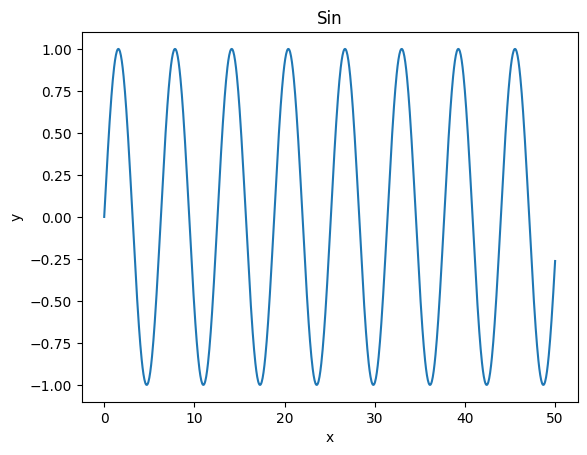

In [11]:
simulator = Sin()
X_test = np.linspace(0, 50, 1000).reshape(-1, 1)
Y_test = simulator(X_test)
plt.plot(X_test.reshape(-1), Y_test.reshape(-1))
plt.xlabel('x')
plt.ylabel('y')
plt.title(simulator.__class__.__name__)
plt.show()

Now we instantiate all of the different learner, each with its own Gaussian process emulator.

**Adjust the values to see different behaviour!**

In [12]:
# Simulator
X_train = LatinHypercube([(0, 50)]).sample(10)
Y_train = simulator(X_train)

# Learners
learners = [
    Random(
        simulator=simulator, emulator=GP(), 
        X_train=X_train, Y_train=Y_train, p_query=0.1
    ),
    Uncertainty(
        simulator=simulator, emulator=GP(), 
        X_train=X_train, Y_train=Y_train, threshold=0.2
    ),
    Diversity(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train, threshold=1.0
    ),
    PID_Uncertainty(
        simulator=simulator, emulator=GP(), 
        X_train=X_train, Y_train=Y_train, 
        threshold=0.2, target_rate=0.1,
        Kp=1.0, Kd=3.0, Ki=0.0, max_threshold=1.0
    ),
    PID_Diversity(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=3.0, target_rate=0.1,
        Kp=3.0, Kd=5.0, Ki=0.0, max_threshold=5.0
    )
]

# Active learning loop
inputs = LatinHypercube([(0, 50)]).sample(1000)
for learner in learners:
    for x in (pb := tqdm.tqdm(inputs)):
        learner(x)
        pb.set_description(f'{learner.__class__.__name__} | Std = {learner.stds[-1]:.4f} | Rate = {learner.rates[-1]:.4f}')

Random | Std = 0.0153 | Rate = 0.0950: 100%|██████████| 1000/1000 [00:12<00:00, 81.89it/s]
Uncertainty | Std = 0.0620 | Rate = 0.0220: 100%|██████████| 1000/1000 [00:03<00:00, 280.43it/s]
Diversity | Std = 0.0210 | Rate = 0.0300: 100%|██████████| 1000/1000 [00:04<00:00, 228.80it/s]
PID_Uncertainty | Std = 0.0151 | Rate = 0.1000: 100%|██████████| 1000/1000 [00:12<00:00, 77.80it/s]
PID_Diversity | Std = 0.0150 | Rate = 0.1020: 100%|██████████| 1000/1000 [00:13<00:00, 71.90it/s]


This plot shows the evolution of the emulator's uncertainty (predictive standard deviation) as active learning proceeds, smoothed using a moving average window. Each curve corresponds to a different stream-based active learning strategy, highlighting how effectively each approach reduces emulator uncertainty over time. A lower standard deviation indicates greater confidence in the emulator’s predictions, reflecting the quality and efficiency of the active learning method.

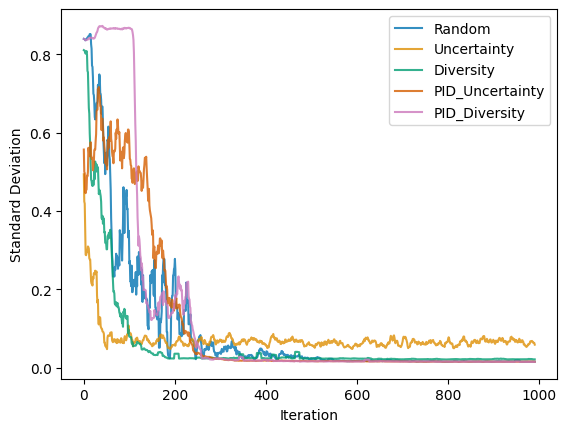

In [13]:
window = 10
palette = sns.color_palette("colorblind", n_colors=len(learners))
for i, learner in enumerate(learners):
    plt.plot(
        np.convolve(learner.stds, np.ones(window) / window, mode='valid'),
        label=learner.__class__.__name__, alpha=0.8, color=palette[i]
    )
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Standard Deviation')
plt.show()

This plot illustrates how the **query rate** (the fraction of input samples for which the simulator is queried) evolves over iterations for each stream-based active learning strategy. The horizontal dashed line represents the **target query rate** (0.1), allowing you to easily compare how well each learner achieves or maintains this target. An effective learner should maintain a stable query rate close to the target, balancing prediction accuracy with simulation cost.

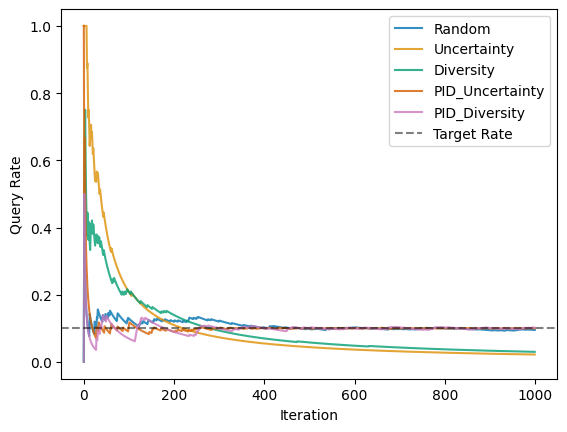

In [14]:
for i, learner in enumerate(learners):
    plt.plot(learner.rates, label=learner.__class__.__name__, alpha=0.8, color=palette[i])
plt.axhline(y=0.1, color="k", linestyle="--", alpha=0.5, label="Target Rate")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Query Rate')
plt.show()

**Running $R^2$ Score Over Iterations**

This plot shows how the cumulative $R^2$ score of each active learning strategy evolves over time. For each learner, we plot the running $R^2$ values (starting from the third iteration to avoid initial noise) using a distinct color from the selected palette. The $R^2$ score is computed as:

$$
R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
$$

where $y_{\text{true}}$ is the simulator output, $y_{\text{pred}}$ is the emulator's prediction, and $\bar{y}$ is the mean of the true values.

- $R^2 = 1$ indicates a perfect fit.
- $R^2 = 0$ means the model performs no better than predicting the mean.
- $R^2 < 0$ suggests the model is performing worse than a naive mean predictor.

The x-axis represents the number of iterations, and the y-axis shows the $R^2$ score (ranging from -1 to 1). This visualization allows us to compare the performance and learning dynamics of different active learning strategies. Note that the differnt learners have different length curves, because this metric is only recorded for accepted queries (which there are a different number between learners).

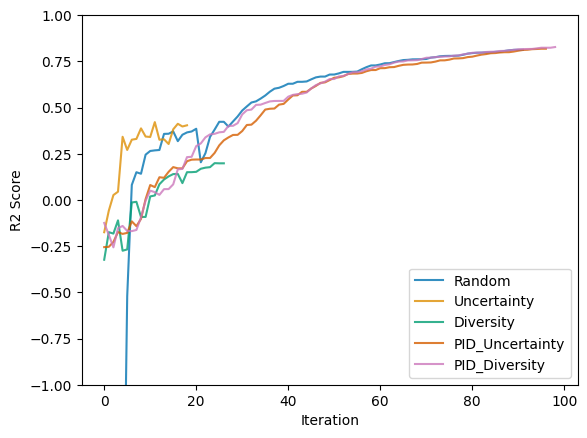

In [15]:
for i, learner in enumerate(learners):
    plt.plot(learner.r2[2:], label=learner.__class__.__name__, alpha=0.8, color=palette[i])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('R2 Score')
plt.ylim(-1, 1)
plt.show()

Now, we can specifically compare the uncertainty based methods. As we see, with the standard one, the threshold is constant, but with the PID one, the threshold is changing over iterations.

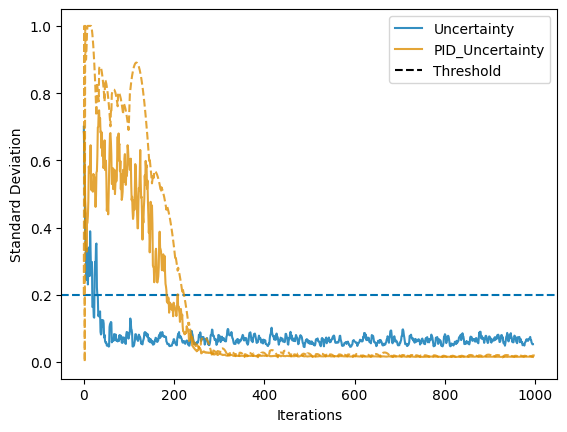

In [16]:
window = 5
palette = sns.color_palette("colorblind", n_colors=2)
for i, learner in enumerate([learner for learner in learners if isinstance(learner, Uncertainty)]):
    plt.plot(
        np.convolve(learner.stds, np.ones(window) / window, mode='valid'),
        label=learner.__class__.__name__, alpha=0.8, color=palette[i]
    )
    if isinstance(learner, PID):
        plt.plot(learner.thresholds, alpha=0.8, color=palette[i], linestyle="--")
    else:
        plt.axhline(y=learner.threshold, color=palette[i], linestyle="--")
plt.plot([], [], linestyle="--", color="black", label="Threshold")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.show()

Now, we can specifically compare the diversity based methods. As we see, with the standard one, the threshold is constant, but with the PID one, the threshold is changing over iterations.

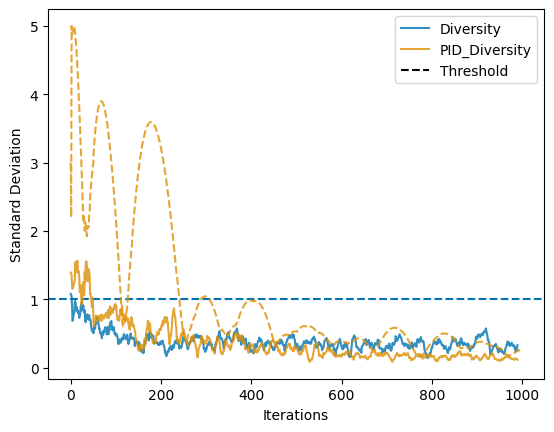

In [17]:
window = 10
palette = sns.color_palette("colorblind", n_colors=2)
for i, learner in enumerate([learner for learner in learners if isinstance(learner, Diversity)]):
    plt.plot(
        np.convolve(learner.distances, np.ones(window) / window, mode='valid'),
        label=learner.__class__.__name__, alpha=0.8, color=palette[i]
    )
    if isinstance(learner, PID):
        plt.plot(learner.thresholds, alpha=0.8, color=palette[i], linestyle="--")
    else:
        plt.axhline(y=learner.threshold, color=palette[i], linestyle="--")
plt.plot([], [], linestyle="--", color="black", label="Threshold")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation')
plt.show()